# Import libraries and packages

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Classifer #2: ResNet-50 Phase 1B

In Phase 1, we will train our ResNet-50 model with the Pascal VOC dataset while allowing each layer to update. We will evaluate the classifer's performance in detecting the target ITO-EN green tea bottle in the test dataset. This will allow us to answer the question, "How well does ResNet-50 detect the ITO-EN bottle with a publicly available dataset?" 

In Phase 2, we will perform transfer learning, where we fix the weights of ResNet-50 (i.e., freeze the convolutional layers) and re-train the fully connected layers with the ITO-EN synthetic dataset. After testing the Phase 2 ResNet-50 on the test dataset of real-world ITO-EN images, we will compare its results with Phase 1 and conclude whether the synthetic dataset improved performance.

## Data Pre-Processing

In [ ]:
# BASE_FOLDER = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/'
# TRAIN_IMAGEPATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/train_images_with_labels.csv'
# VAL_IMAGEPATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/val_images_with_labels.csv'
# TEST_IMAGEPATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/test_images_with_labels.csv'
# ITOEN_PUBLIC_IMAGEPATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/ALL_ITO-EN_IMAGES_RESIZED/'
# SYNTHETIC_IMAGEPATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/ALL_SYNTHETIC_IMAGES_RESIZED/'

# # ITOEN_PUBLIC_IMAGEPATH
# import os
# files = os.listdir(ITOEN_PUBLIC_IMAGEPATH)
# file_paths = []
# for file in files:
#     file_paths.append(ITOEN_PUBLIC_IMAGEPATH + file)
# df = pd.DataFrame(file_paths)
# df.columns = ['filepath']
# df['image_label'] = 'bottle'
# df.to_csv(BASE_FOLDER + 'itoen_public_labelpath_vh.csv', index=False)

In [ ]:
# # SYNTHETIC_IMAGEPATH
# import os
# files = os.listdir(SYNTHETIC_IMAGEPATH)
# file_paths = []
# for file in files:
#     file_paths.append(SYNTHETIC_IMAGEPATH + file)
# df = pd.DataFrame(file_paths)
# df.columns = ['filepath']
# df['image_label'] = 'bottle'
# df.to_csv(BASE_FOLDER + 'synthetic_labelpath_vh.csv', index=False)

In [8]:
TRAIN_LABELPATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/train_images_with_labels.csv'
VAL_LABELPATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/val_images_with_labels.csv'
TEST_LABELPATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/test_images_with_labels.csv'
SYNTHETIC_LABELPATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/synthetic_labelpath_vh.csv'
ITOEN_PUBLIC_LABELPATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/itoen_public_labelpath_vh.csv'

train = pd.read_csv(TRAIN_LABELPATH)
val = pd.read_csv(VAL_LABELPATH)
test = pd.read_csv(TEST_LABELPATH)
synthetic = pd.read_csv(SYNTHETIC_LABELPATH)
itoen = pd.read_csv(ITOEN_PUBLIC_LABELPATH)


train.columns = ['ignore_value', 'image_ID', 'filepath', 'image_label']
val.columns = ['ignore_value', 'image_ID', 'filepath', 'image_label']
test.columns = ['ignore_value', 'image_ID', 'filepath', 'image_label']

test_itoen = pd.concat([test, itoen])
train_synthetic = pd.concat([train, synthetic])

In [9]:
# Pascal VOC Dataset
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.1)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [10]:
# Synthetic Dataset
synthetic_train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.1)


In [11]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(
                    input_shape=(128, 128, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg')

pretrained_model.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='filepath',
    y_col='image_label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val,
    x_col='filepath',
    y_col='image_label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_itoen,
    x_col='filepath',
    y_col='image_label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

Found 14954 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


Found 237 validated image filenames belonging to 20 classes.
Found 5264 validated image filenames belonging to 20 classes.


In [13]:
synthetic_train_images = synthetic_train_generator.flow_from_dataframe(
    dataframe=train_synthetic,
    x_col='filepath',
    y_col='image_label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

synthetic_val_images = synthetic_train_generator.flow_from_dataframe(
    dataframe=train_synthetic,
    x_col='filepath',
    y_col='image_label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 22155 validated image filenames belonging to 20 classes.
Found 2461 validated image filenames belonging to 20 classes.


In [14]:
batch_size = 32
training_epochs = [20, 20]
IMG_SIZE = (128, 128) 
IMG_SHAPE = IMG_SIZE + (3,)
classes = 20

In [15]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu')(x)
outputs = tf.keras.layers.Dense(20, activation='softmax')(x)
phase1_model = tf.keras.Model(inputs, outputs)
print(phase1_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [39]:
phase1_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')

In [40]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
history = phase1_model.fit(train_images,validation_data=val_images,epochs=20,
    callbacks=[callbacks])

Epoch 1/20
468/468 [==============================] - 9255s 20s/step - loss: 1.1799 - accuracy: 0.6526 - val_loss: 0.8347 - val_accuracy: 0.7046
Epoch 2/20
468/468 [==============================] - 43s 92ms/step - loss: 0.8128 - accuracy: 0.7452 - val_loss: 0.7965 - val_accuracy: 0.7342
Epoch 3/20
468/468 [==============================] - 43s 93ms/step - loss: 0.6862 - accuracy: 0.7806 - val_loss: 0.7858 - val_accuracy: 0.7300
Epoch 4/20
468/468 [==============================] - 43s 91ms/step - loss: 0.5858 - accuracy: 0.8096 - val_loss: 0.8275 - val_accuracy: 0.7300
Epoch 5/20
468/468 [==============================] - 43s 92ms/step - loss: 0.4927 - accuracy: 0.8358 - val_loss: 0.8501 - val_accuracy: 0.7004
Epoch 6/20
468/468 [==============================] - 43s 92ms/step - loss: 0.4083 - accuracy: 0.8638 - val_loss: 0.8402 - val_accuracy: 0.7426


In [41]:
# save the model
index = 0 
p = '/content/drive/MyDrive/DATASCI281_FinalProject/02_results/phase01_resnet50_run0/phase1_run' + str(index) 

while os.path.exists(p):
  index += 1
  p = '/content/drive/MyDrive/DATASCI281_FinalProject/02_results/phase01_resnet50_run0/phase1_run' + str(index) 

os.makedirs(p)
phase1_model.save(str(p))
print("The latest Phase1 Model is saved here:", str(p))

## latest run
# /content/drive/MyDrive/DATASCI281_FinalProject/02_results/phase01_resnet50_run0/phase1_run2

The latest Phase1 Model is saved here: /content/drive/MyDrive/DATASCI281_FinalProject/02_results/phase01_resnet50_run0/phase1_run2


In [42]:
# Defining path to the trained model
path_to_phase1_model = '/content/drive/MyDrive/DATASCI281_FinalProject/02_results/phase01_resnet50_run0/phase1_run2'

# Load the trained model
phase1_model = keras.models.load_model(path_to_phase1_model)

In [43]:
results = phase1_model.evaluate(test_images)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

165/165 [==============================] - 16s 88ms/step - loss: 1.0029 - accuracy: 0.7145
[1.0028990507125854, 0.714475691318512]
Test Accuracy: 71.45%


In [44]:
predictions = np.argmax(phase1_model.predict(test_images), axis=1)
matrix = confusion_matrix(test_images.labels, predictions)
report_phase1= classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

165/165 [==============================] - 16s 90ms/step


In [45]:
print('these are test image labels:', test_images.labels)
print('these are predictions:', predictions)

these are test image labels: [14, 14, 12, 17, 14, 6, 14, 14, 1, 14, 4, 14, 14, 14, 13, 5, 9, 14, 14, 14, 2, 14, 16, 14, 15, 13, 19, 13, 7, 18, 9, 11, 14, 4, 8, 6, 7, 14, 2, 8, 14, 6, 2, 14, 8, 14, 7, 11, 11, 8, 14, 6, 1, 4, 14, 8, 14, 13, 2, 14, 19, 14, 13, 14, 14, 14, 10, 13, 14, 14, 14, 5, 14, 4, 5, 4, 14, 11, 14, 17, 14, 11, 14, 14, 6, 14, 8, 14, 4, 14, 8, 19, 0, 1, 3, 18, 2, 14, 9, 6, 8, 11, 14, 8, 14, 8, 7, 14, 14, 3, 19, 6, 7, 14, 4, 14, 4, 11, 14, 1, 14, 14, 14, 8, 6, 1, 14, 10, 11, 19, 1, 7, 18, 14, 0, 14, 7, 2, 19, 3, 14, 16, 4, 3, 5, 0, 11, 4, 6, 1, 14, 0, 14, 10, 0, 6, 14, 14, 11, 18, 14, 4, 0, 7, 14, 14, 17, 11, 14, 15, 0, 6, 14, 6, 19, 1, 19, 14, 4, 3, 14, 16, 4, 8, 14, 6, 14, 11, 14, 2, 14, 14, 11, 14, 1, 7, 12, 10, 14, 15, 0, 19, 14, 5, 8, 19, 8, 11, 15, 11, 8, 10, 11, 0, 14, 8, 13, 1, 14, 13, 14, 14, 14, 14, 14, 14, 14, 8, 7, 1, 13, 14, 14, 17, 9, 14, 8, 14, 14, 8, 2, 14, 14, 18, 14, 8, 14, 14, 6, 7, 11, 1, 14, 4, 14, 14, 14, 7, 15, 15, 11, 10, 2, 0, 11, 14, 14, 2, 14, 

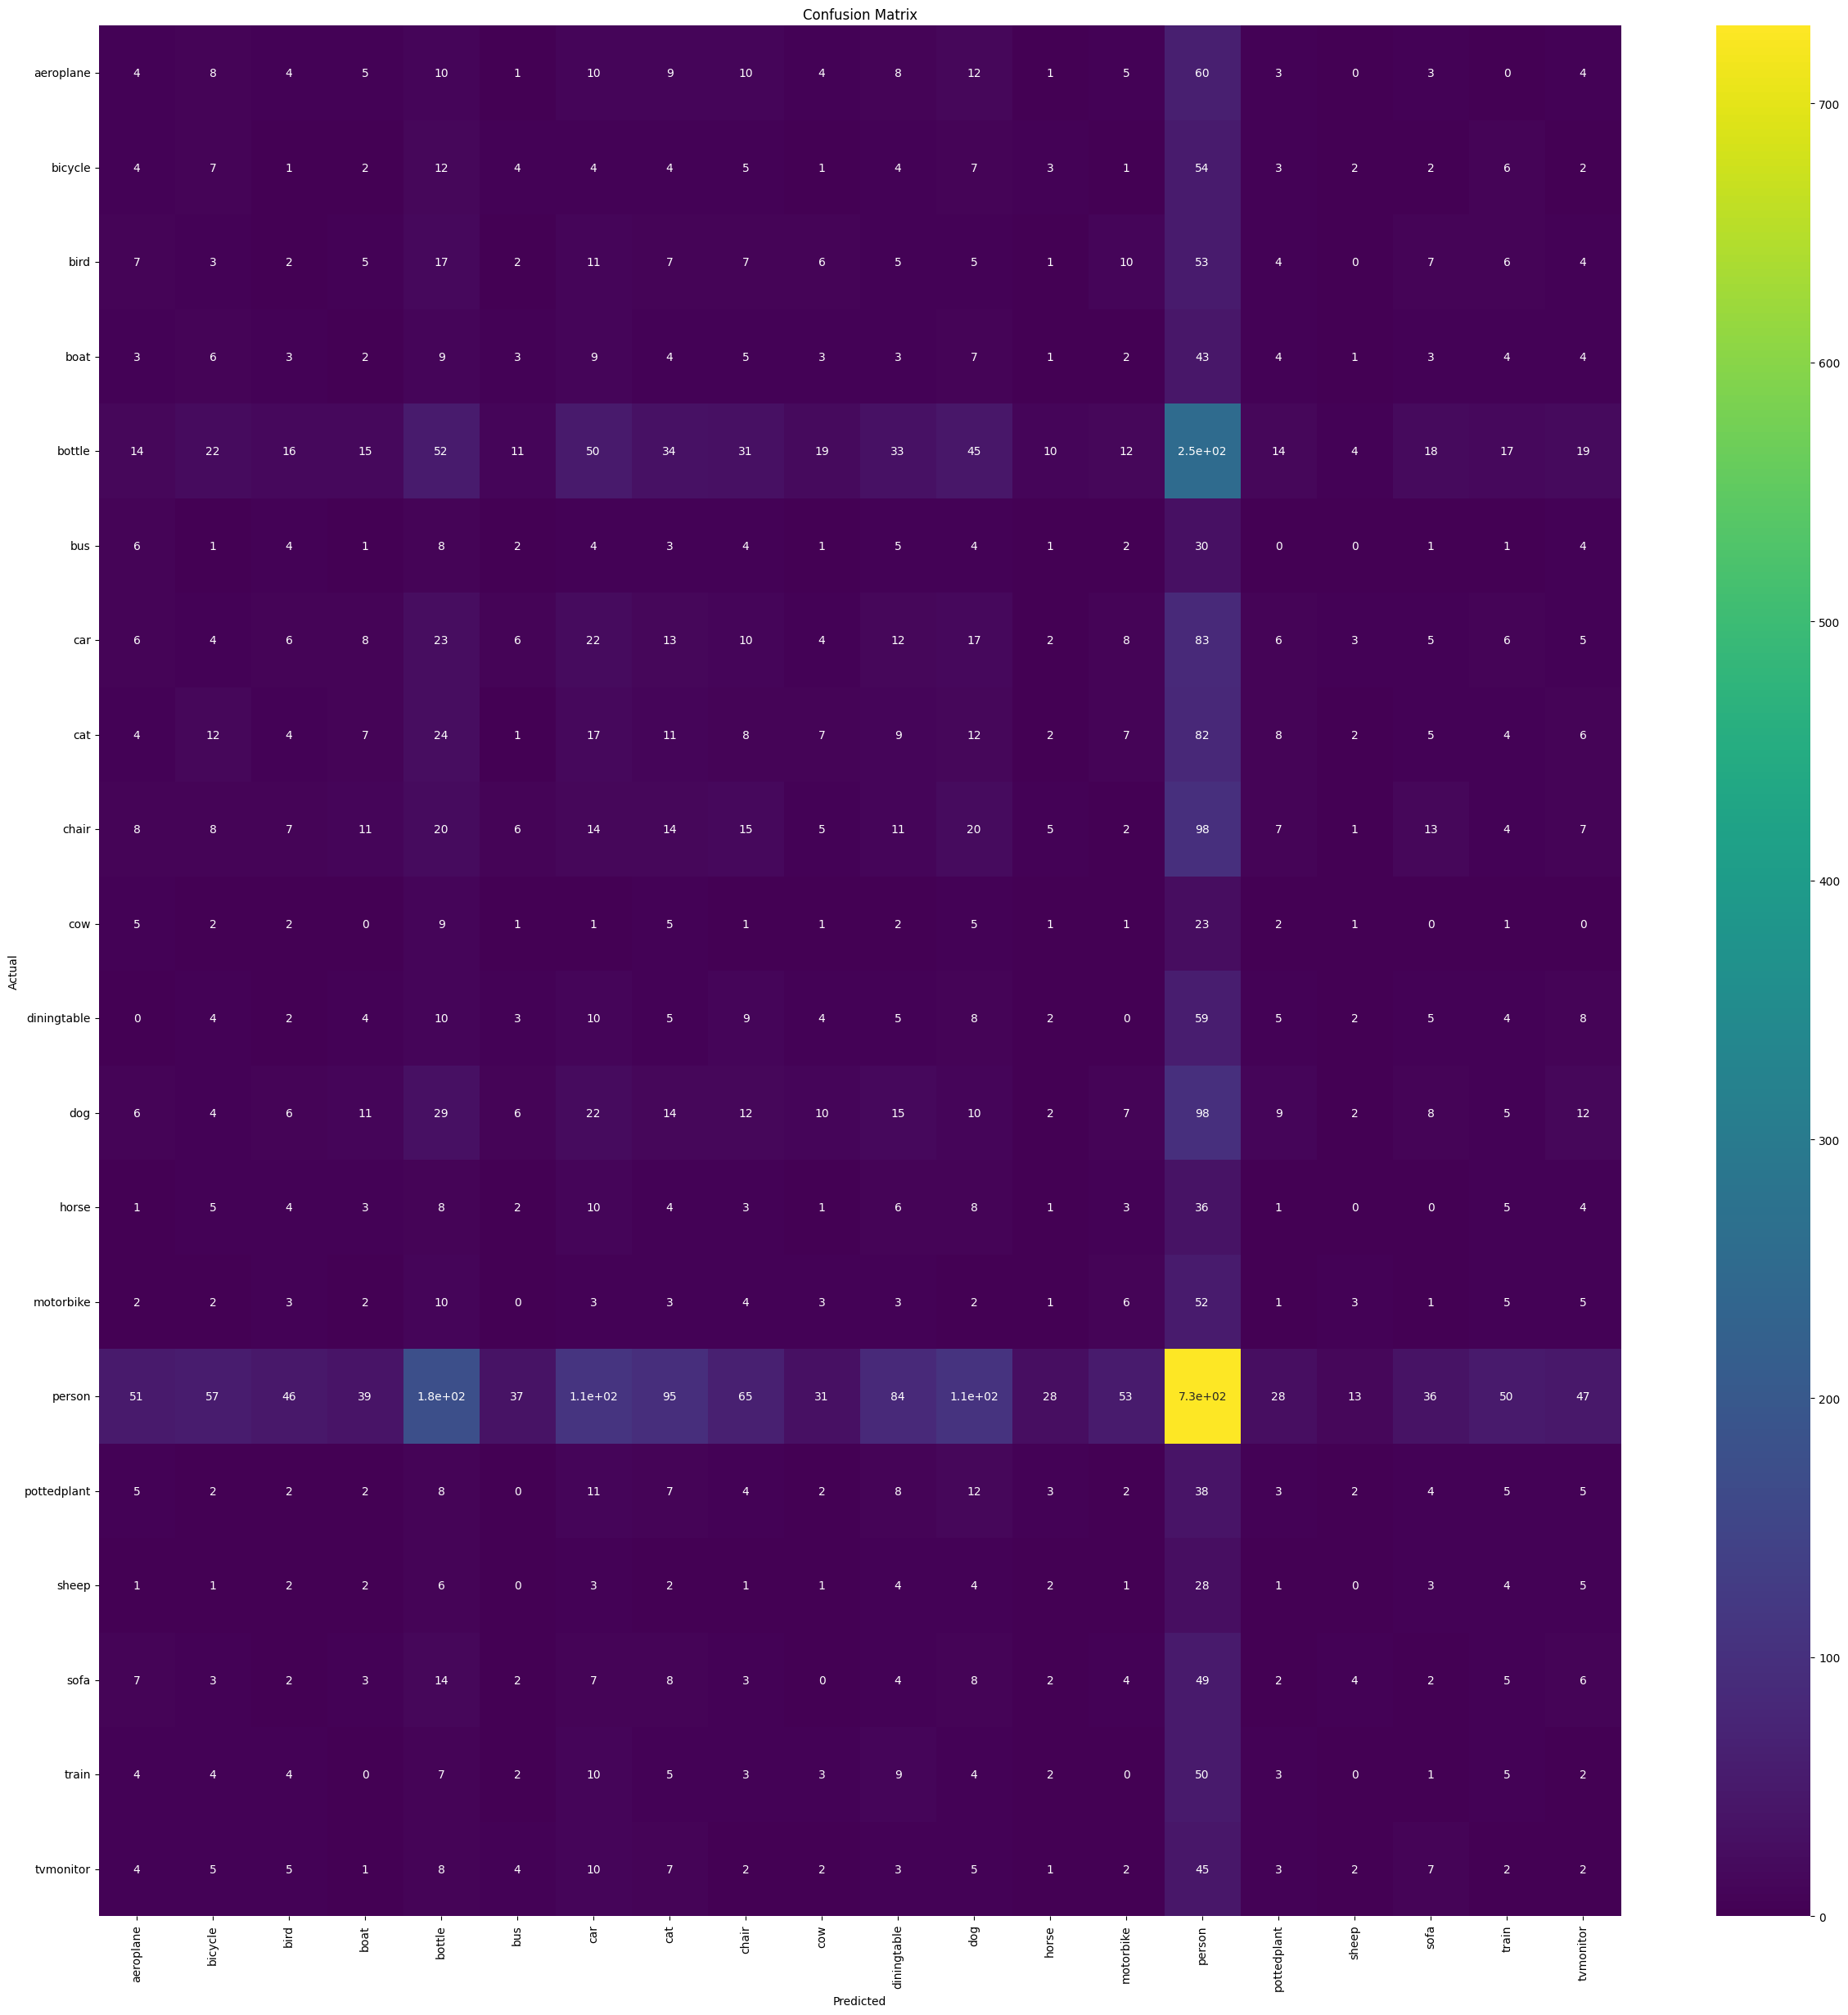

In [46]:
fig = plt.figure(figsize=(30, 30))
sns.heatmap(matrix, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fig.savefig("Confusion Matrix",dpi=700)

In [47]:
print("Classification Report:\n", report_phase1)

Classification Report:
               precision    recall  f1-score   support

   aeroplane       0.03      0.02      0.03       161
     bicycle       0.04      0.05      0.05       128
        bird       0.02      0.01      0.01       162
        boat       0.02      0.02      0.02       119
      bottle       0.11      0.08      0.09       688
         bus       0.02      0.02      0.02        82
         car       0.07      0.09      0.07       249
         cat       0.04      0.05      0.05       232
       chair       0.07      0.05      0.06       276
         cow       0.01      0.02      0.01        63
 diningtable       0.02      0.03      0.03       149
         dog       0.03      0.03      0.03       288
       horse       0.01      0.01      0.01       105
   motorbike       0.05      0.05      0.05       111
      person       0.37      0.39      0.38      1882
 pottedplant       0.03      0.02      0.03       125
       sheep       0.00      0.00      0.00        71
   

In [48]:
data_his = pd.DataFrame(history.history)
data_his

,loss,accuracy,val_loss,val_accuracy
0,1.179910,0.652558,0.834653,0.704641
1,0.812848,0.745236,0.796460,0.734177
2,0.686246,0.780608,0.785770,0.729958
3,0.585838,0.809629,0.827497,0.729958
4,0.492677,0.835841,0.850111,0.700422
5,0.408296,0.863791,0.840167,0.742616


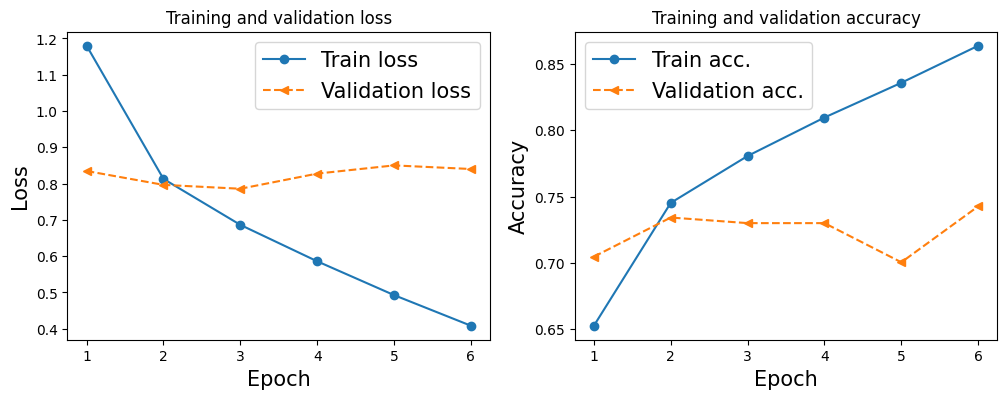

In [49]:
hist = history.history

x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
plt.title('Training and validation loss')

print('\n')
print('\n')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.title('Training and validation accuracy')
plt.show()

# Classifer #2: ResNet-50 Phase 2

In [16]:
# Defining path to the trained model
path_to_trained_model = '/content/drive/MyDrive/DATASCI281_FinalProject/02_results/phase01_resnet50_run0/phase1_run2'

# Load the trained model
trained_model = keras.models.load_model(path_to_trained_model)

In [17]:
# Phase 2: Fine tuning
trained_model.trainable = True
print("We are making all the layers untrainable except the last layer. \n")
for layer in trained_model.layers[:-1]:
    layer.trainable=False

We are making all the layers untrainable except the last layer. 



In [20]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

trained_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics='accuracy')

phase_2_history = trained_model.fit(
    synthetic_train_images,
    epochs=sum(training_epochs),
    initial_epoch=6, 
    validation_data = synthetic_val_images, callbacks=[callbacks])

Epoch 7/40
693/693 [==============================] - 4179s 6s/step - loss: 0.3818 - accuracy: 0.8819 - val_loss: 0.7815 - val_accuracy: 0.7582
Epoch 8/40
693/693 [==============================] - 65s 94ms/step - loss: 0.3435 - accuracy: 0.8900 - val_loss: 0.7900 - val_accuracy: 0.7562
Epoch 9/40
693/693 [==============================] - 64s 93ms/step - loss: 0.3371 - accuracy: 0.8922 - val_loss: 0.7929 - val_accuracy: 0.7546
Epoch 10/40
693/693 [==============================] - 65s 93ms/step - loss: 0.3323 - accuracy: 0.8929 - val_loss: 0.8031 - val_accuracy: 0.7501


In [21]:
# save the model
index = 0 
p = '/content/drive/MyDrive/DATASCI281_FinalProject/02_results/phase02_resnet50_run' + str(index) 

while os.path.exists(p):
  index += 1
  p = '/content/drive/MyDrive/DATASCI281_FinalProject/02_results/phase02_resnet50_run' + str(index) 

os.makedirs(p)
phase1_model.save(str(p))
print("The latest Phase2 Model is saved here:", str(p))

# /content/drive/MyDrive/DATASCI281_FinalProject/02_results/phase02_resnet50_run1

The latest Phase2 Model is saved here: /content/drive/MyDrive/DATASCI281_FinalProject/02_results/phase02_resnet50_run1


In [25]:
phase2_results = trained_model.evaluate(test_images)
print(phase2_results)
print(f"Test Accuracy: {np.round(phase2_results[1] * 100,2)}%")

165/165 [==============================] - 16s 99ms/step - loss: 0.9517 - accuracy: 0.7352
[0.9517066478729248, 0.7351823449134827]
Test Accuracy: 73.52%


In [26]:
predictions2 = np.argmax(trained_model.predict(test_images), axis=1)
matrix2 = confusion_matrix(test_images.labels, predictions2)
report_phase2= classification_report(test_images.labels, predictions2, target_names=test_images.class_indices, zero_division=0)

165/165 [==============================] - 18s 102ms/step


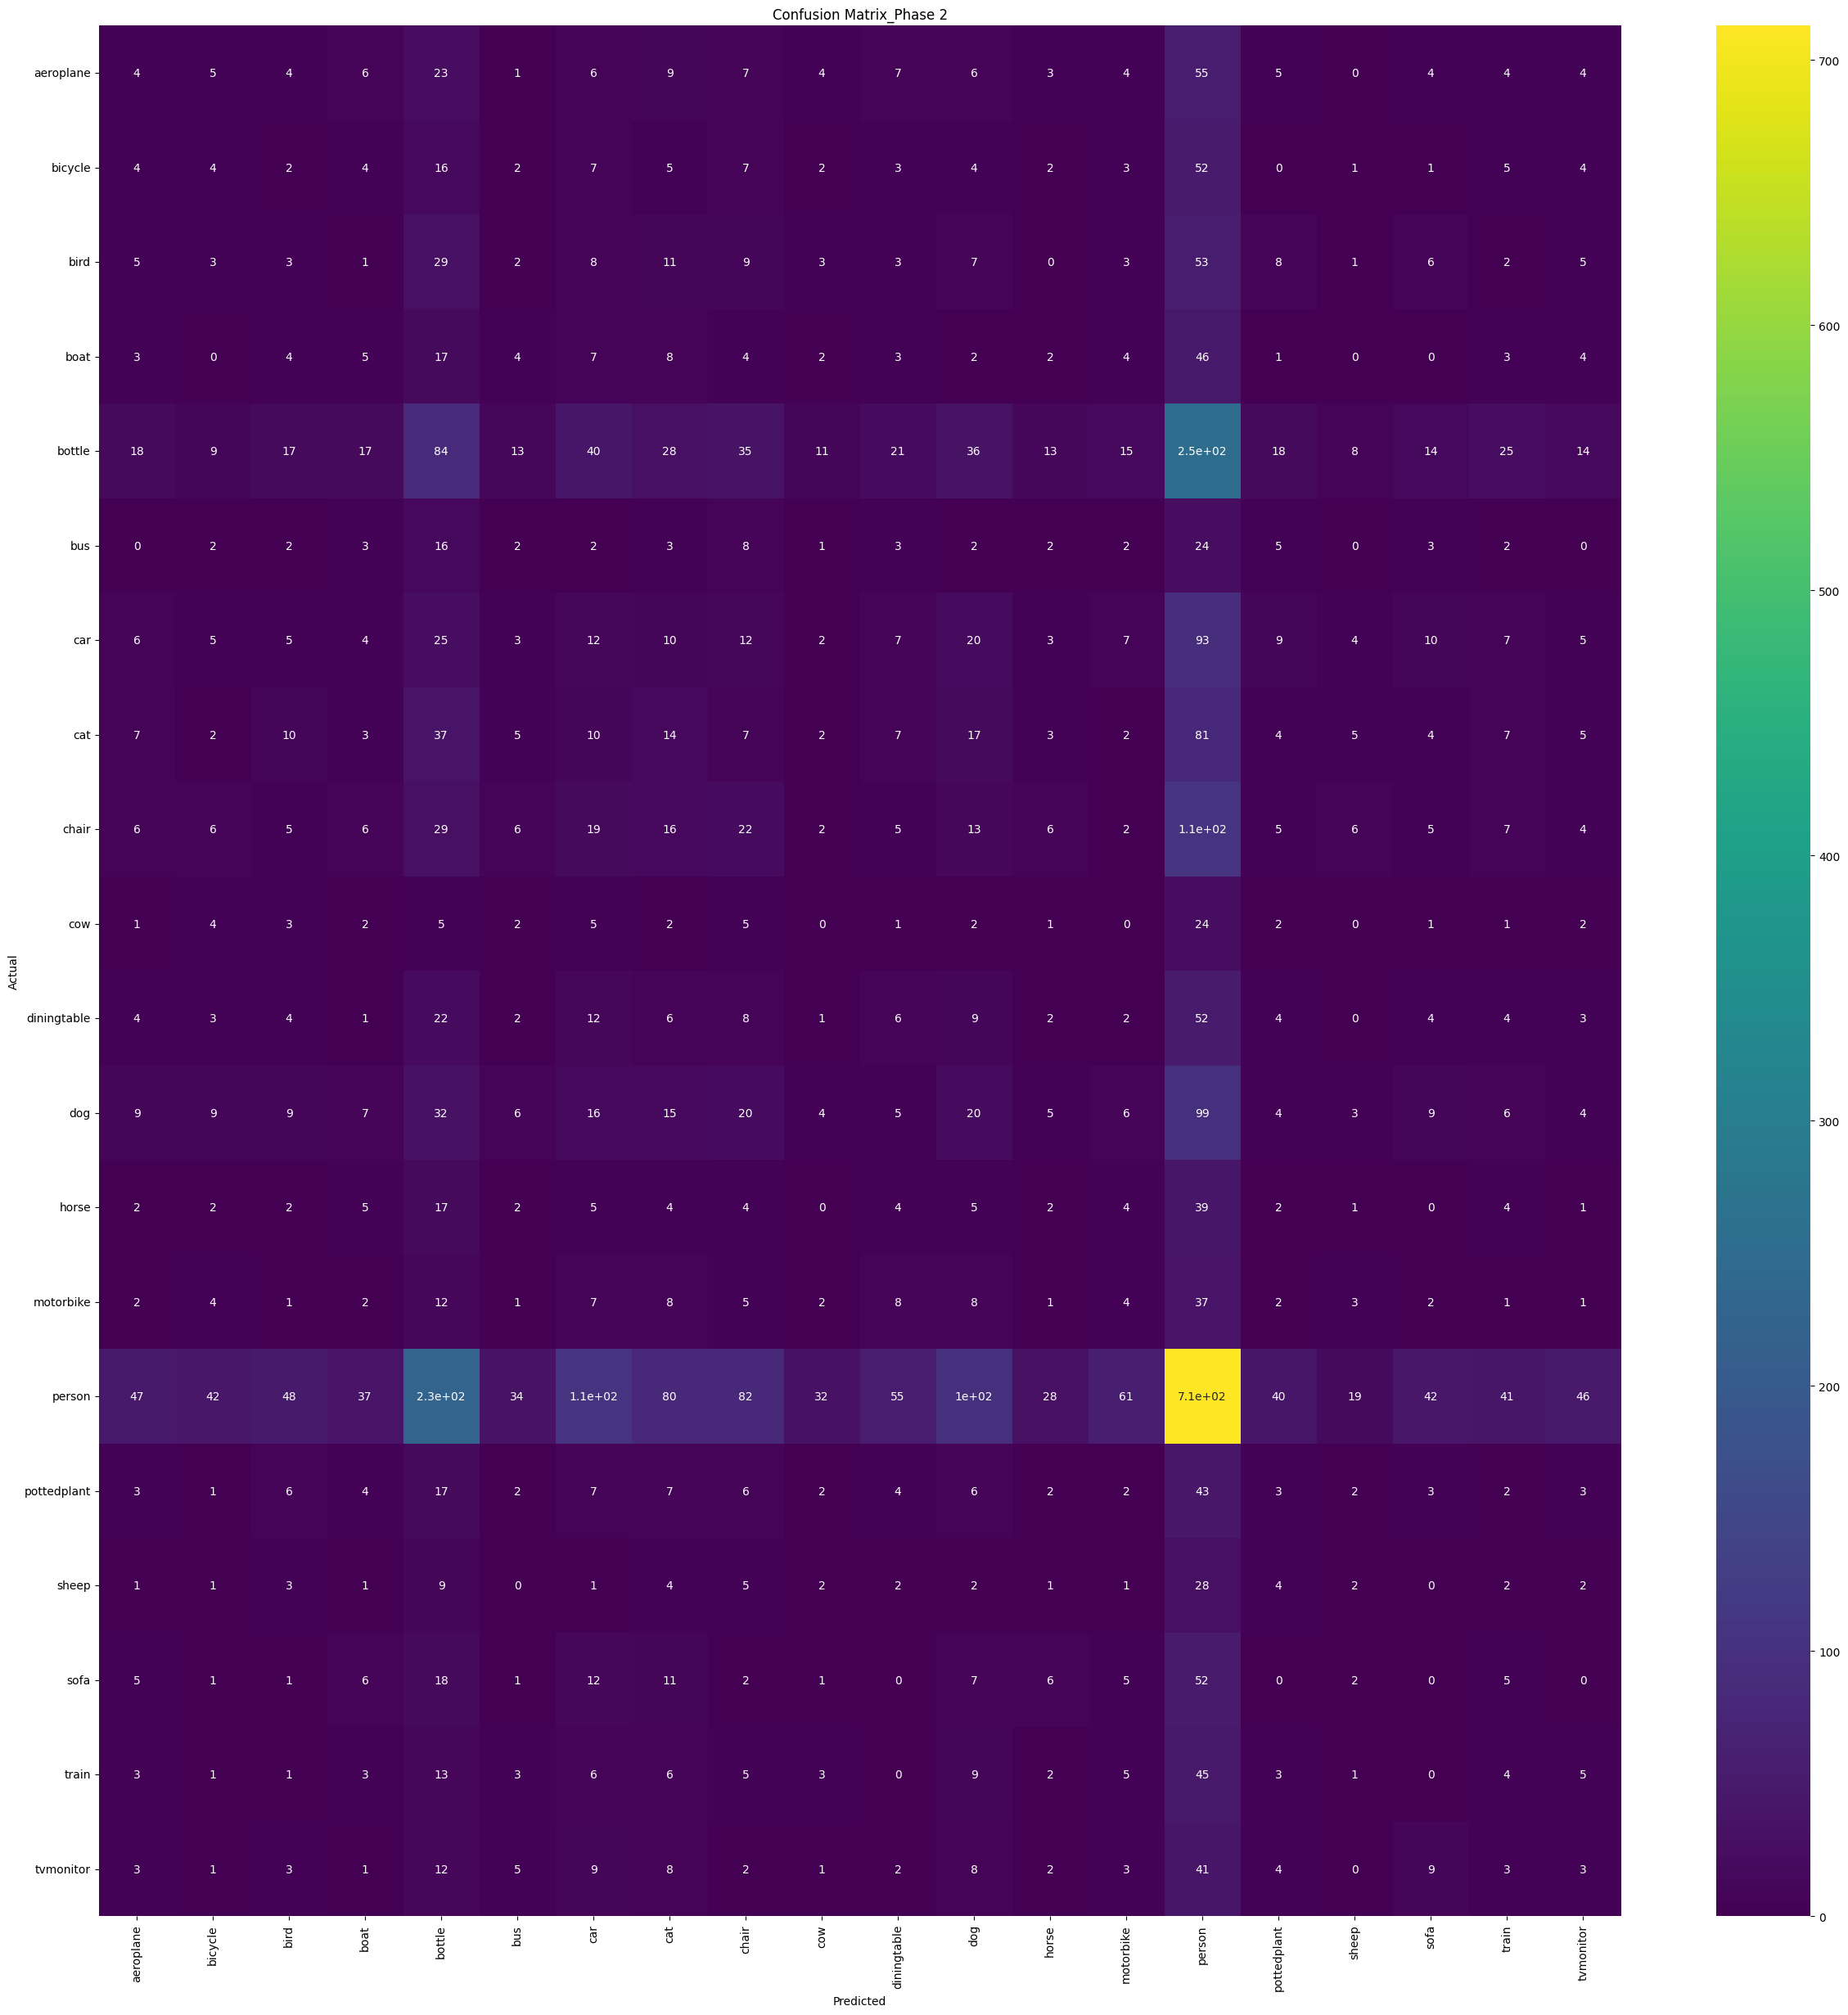

In [27]:
fig = plt.figure(figsize=(30, 30))
sns.heatmap(matrix2, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=0)
plt.title("Confusion Matrix_Phase 2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fig.savefig("Confusion Matrix_Phase 2",dpi=700)

In [28]:
print("Classification Report:\n", report_phase2)

Classification Report:
               precision    recall  f1-score   support

   aeroplane       0.03      0.02      0.03       161
     bicycle       0.04      0.03      0.03       128
        bird       0.02      0.02      0.02       162
        boat       0.04      0.04      0.04       119
      bottle       0.13      0.12      0.12       688
         bus       0.02      0.02      0.02        82
         car       0.04      0.05      0.04       249
         cat       0.05      0.06      0.06       232
       chair       0.09      0.08      0.08       276
         cow       0.00      0.00      0.00        63
 diningtable       0.04      0.04      0.04       149
         dog       0.07      0.07      0.07       288
       horse       0.02      0.02      0.02       105
   motorbike       0.03      0.04      0.03       111
      person       0.37      0.38      0.37      1882
 pottedplant       0.02      0.02      0.02       125
       sheep       0.03      0.03      0.03        71
   

In [29]:
data_his_phase2 = pd.DataFrame(phase_2_history.history)
data_his_phase2

,loss,accuracy,val_loss,val_accuracy
0,0.381803,0.881878,0.781485,0.758228
1,0.343499,0.889957,0.789983,0.756197
2,0.337129,0.892169,0.792921,0.754571
3,0.332334,0.892891,0.803053,0.750102


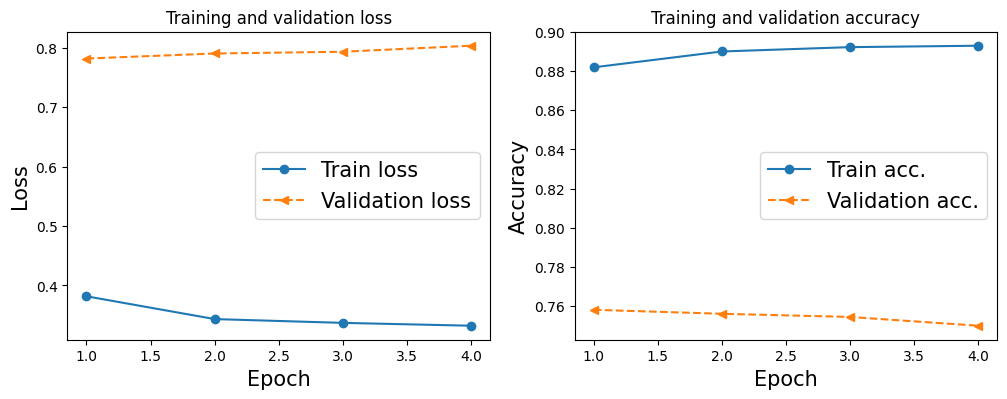

In [30]:
hist = phase_2_history.history

x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
plt.title('Training and validation loss')

print('\n')
print('\n')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.title('Training and validation accuracy')
plt.show()